In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pickle as pkl

from tqdm import tqdm
from importlib import reload

import utils.policies as polc
import utils.experiment as expt
import utils.plotter as pltutils
import utils.sweeper as swpr

reload(polc)
reload(expt)
reload(swpr)
reload(pltutils);

In [2]:
save_directory = './results/regret-sweep' # will not save if set to None
arrival_rates_list = [2,4,6]
noise_variances_list = [0,0.01,0.05,0.1]

pooled_sweep_args = []
for arrival_rate in arrival_rates_list:
    for noise_variance in noise_variances_list:
        pooled_sweep_args.append((arrival_rate, noise_variance, save_directory))
print(pooled_sweep_args)

[(2, 0, './results/regret-sweep'), (2, 0.01, './results/regret-sweep'), (2, 0.05, './results/regret-sweep'), (2, 0.1, './results/regret-sweep'), (4, 0, './results/regret-sweep'), (4, 0.01, './results/regret-sweep'), (4, 0.05, './results/regret-sweep'), (4, 0.1, './results/regret-sweep'), (6, 0, './results/regret-sweep'), (6, 0.01, './results/regret-sweep'), (6, 0.05, './results/regret-sweep'), (6, 0.1, './results/regret-sweep')]


In [ ]:
if __name__ == '__main__':
    with Pool() as pool:
        list(tqdm(pool.imap(swpr.perform_regret_experiment, pooled_sweep_args), total=len(pooled_sweep_args)))
        pool.close()
        pool.join()

  0%|          | 0/12 [00:00<?, ?it/s]

Arrival rate = 2, noise variance = 0
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Fit co-effs [1 sqrt(T)log(T)] = [15.981  1.66 ]
 
Arrival rate = 2, noise variance = 0.01
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.256 0.448 0.165 0.193 0.295 0.091 0.122 0.155 0.128 0.144 0.007 0.26
 0.212 0.171 0.075]
Fit co-effs [1 sqrt(T)log(T)] = [20.034  3.402]
 
Arrival rate = 2, noise variance = 0.05
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.324 0.383 0.245 0.308 0.411 0.079 0.149 0.223 0.163 0.199 0.106 0.21
 0.103 0.26  0.043]
Fit co-effs [1 sqrt(T)log(T)] = [9.932 5.897]
 
Arrival rate = 2, noise variance = 0.1
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.376 0.334 0.305 0.395 0.499 0.071 0.169 0.274 0.19  0.24  0

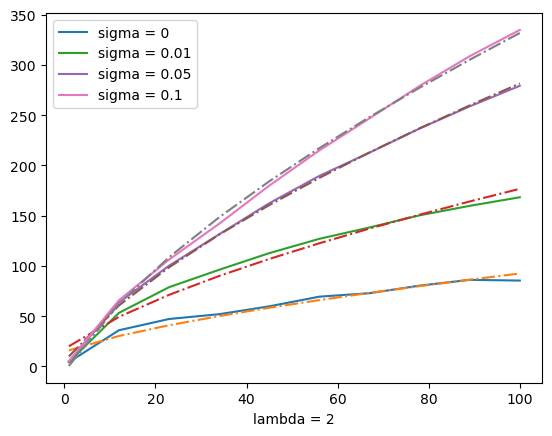

Arrival rate = 4, noise variance = 0
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Fit co-effs [1 sqrt(T)log(T)] = [26.77   2.253]
 
Arrival rate = 4, noise variance = 0.01
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.256 0.448 0.165 0.193 0.295 0.091 0.122 0.155 0.128 0.144 0.007 0.26
 0.212 0.171 0.075]
Fit co-effs [1 sqrt(T)log(T)] = [27.919  3.244]
 
Arrival rate = 4, noise variance = 0.05
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [ 0.324  0.383  0.245  0.308  0.411  0.079  0.149  0.223  0.163  0.199
 -0.037  0.21   0.103  0.26   0.043]
Fit co-effs [1 sqrt(T)log(T)] = [21.087  4.684]
 
Arrival rate = 4, noise variance = 0.1
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [ 0.376  0.334  0.305  0.395  0.499  0.071  

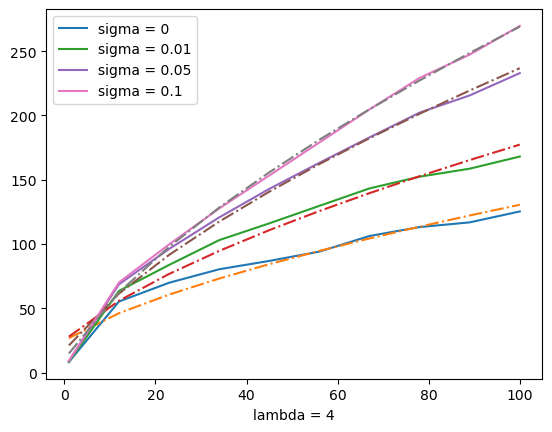

Arrival rate = 6, noise variance = 0
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Fit co-effs [1 sqrt(T)log(T)] = [41.615  2.797]
 
Arrival rate = 6, noise variance = 0.01
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [0.256 0.448 0.165 0.193 0.295 0.091 0.122 0.155 0.128 0.144 0.007 0.26
 0.212 0.171 0.075]
Fit co-effs [1 sqrt(T)log(T)] = [34.893  3.364]
 
Arrival rate = 6, noise variance = 0.05
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [ 0.324  0.383  0.245  0.308  0.411  0.079  0.149  0.223  0.163  0.199
 -0.103  0.21   0.103  0.26   0.043]
Fit co-effs [1 sqrt(T)log(T)] = [32.984  3.397]
 
Arrival rate = 6, noise variance = 0.1
True costs = [0.2 0.5 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3 0.1 0.1]
Mean observed costs = [ 0.376  0.334  0.305  0.395  0.499  0.071  

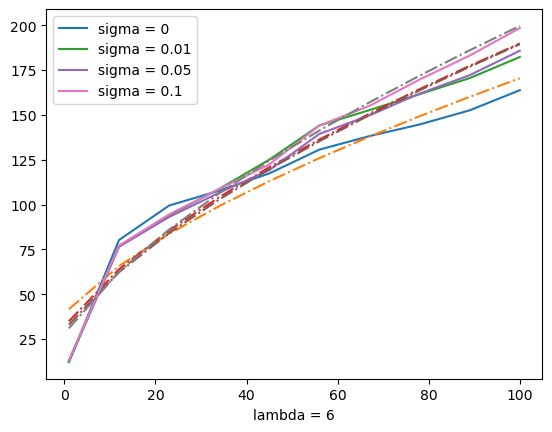

In [ ]:
for arrival_rate in arrival_rates_list:
    for noise_variance in noise_variances_list:
        with open(save_directory + '/regret-lambda-' + str(arrival_rate).replace('.','_') + '-var-' + str(noise_variance).replace('.','_') + '.pkl', 'rb') as f: 
            current_result = pkl.load(f)   

        dpop_costs =  current_result['dpop_costs']
        stat_costs = current_result['stat_costs']
        T_horizon_list = current_result['T_horizon_list']
        true_edge_costs = current_result['true_edge_costs']
        example_edge_cost_means = current_result['example_edge_cost_means']

        # print summary
        print('Arrival rate = ' + str(arrival_rate) + ', noise variance = ' + str(noise_variance))
        print('True costs = ' + str(true_edge_costs))
        print('Mean observed costs = ' + np.array2string(example_edge_cost_means, precision=3, suppress_small=True))

        # get theoretical fit
        dpop_regret = dpop_costs - stat_costs
        theoretical_dpop_regret = pltutils.fit_regret_curve(T_horizon_list, dpop_regret)
        print(' ')

        # plot regret
        plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'sigma = ' + str(noise_variance))
        plt.plot(T_horizon_list, theoretical_dpop_regret, '-.')
    plt.legend()
    plt.xlabel('lambda = ' + str(arrival_rate))
    plt.show()